In [1]:
from projectyl.dynamics.inverse_kinematics import build_arm_model
global_params = {}
build_arm_model(global_params, headless=False)
arm_robot = global_params["arm"]
viz = global_params["viz"]


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [2]:
import time 

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pinocchio as pin
from scipy.optimize import least_squares
from scipy.special import huber
from projectyl.utils.properties import ELBOW, SHOULDER, WRIST, RIGHT, LEFT
from projectyl.video.props import INTRINSIC_MATRIX, THUMBS, SIZE
from pathlib import Path
from projectyl.dynamics.inverse_kinematics import forward_kinematics
from projectyl.utils.arm import retrieve_arm_estimation
from projectyl.utils.camera_projection import project_3D_point
from projectyl.utils.pose_overlay import get_4D_homogeneous_vector
from projectyl.utils.io import Dump
from projectyl import root_dir
from projectyl.utils.camera_projection import get_4D_homogeneous_vector
from interactive_pipe.helper import _private
from scipy.optimize import least_squares
from typing import List
_private.registered_controls_names = [] # this is for notebooks where you re-execute cells everytime.

%load_ext autoreload
%autoreload 2



SIMULATION = "simulation"
REAL = "real"
camera_calibration_path = root_dir/"calibration"/"camera_calibration_xiaomi_mi11_ultra_video_vertical.json"
calib_dict = Dump.load_json(Path(camera_calibration_path))
intrinsic_matrix = np.array(calib_dict[INTRINSIC_MATRIX])
intrinsic_matrix


array([[1.69010663e+03, 0.00000000e+00, 5.34817898e+02],
       [0.00000000e+00, 1.69233647e+03, 9.43177198e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [3]:
mode = REAL
# video_path = Path(root_dir)/"__out/0009_weight_lifting_main_camera_30fps"
video_path = Path(root_dir)/"__out/0011_arm_calibration"
# video_path = Path(root_dir)/"__out/0012_moving_arm"
side = "right"

In [4]:
data3d = Dump.load_pickle(video_path/"coarse_ik.pkl")
data2d = Dump.load_pickle(video_path/"pose"/"pose_sequence.pkl")
# INITIAL STATE LIST
q = np.array(data3d["q"])
T = len(q)

# 3D points
p = ([np.array([el.translation for el in data3d["3dpoints"][member]]).T for member in [SHOULDER, ELBOW, WRIST]])
gt_p_full = np.concatenate(p).T
gt_p_full.shape #T, 9

# initialization from IK estimation
initial_full = np.concatenate([q, np.zeros((T, 2 * arm_robot.model.nv))], axis=1)
initial_full.shape
DT = 1/30. # 30fps


# 2D points
arm_2d = [retrieve_arm_estimation(data2d, frame_idx=t, arm_side=RIGHT, key="pose_landmarks") for t in range(len(data2d))]
p2d = [np.array([el[member] for el in arm_2d]).T for member in [SHOULDER, ELBOW, WRIST]]
gt_p2d_full = np.concatenate(p2d).T
gt_p2d_full.shape

config = Dump.load_yaml(video_path/"config.yaml", safe_load=False)
h, w = int(config[THUMBS][SIZE][0]), int(config[THUMBS][SIZE][1])
h, w

(1920, 1080)

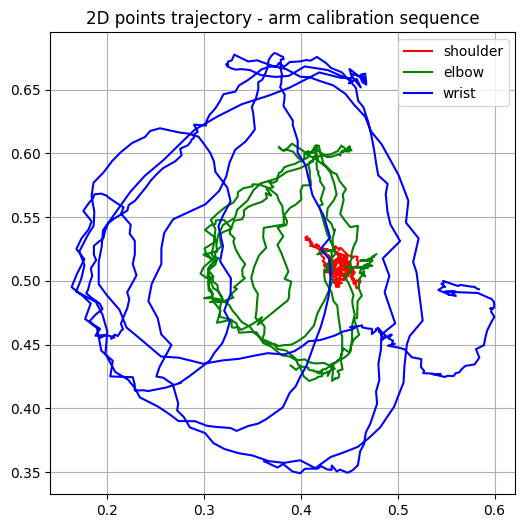

In [5]:
plt.figure(figsize=(6, 6))
t_start, t_end = 0, len(gt_p_full)

for joint_idx, joint_name in enumerate([SHOULDER, ELBOW, WRIST]):

    plt.plot(gt_p2d_full[t_start:t_end, joint_idx * 3 + 0], gt_p2d_full[t_start:t_end, joint_idx * 3 + 1], color="rgb"[joint_idx], label=f"{joint_name}")
# plt.xlim(0, 1)
# plt.ylim(1, 0)
plt.grid()
plt.legend()
plt.title("2D points trajectory - arm calibration sequence")
plt.show()

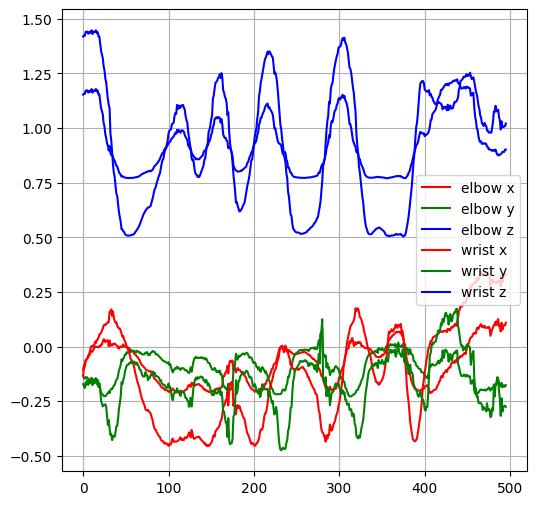

In [6]:
plt.figure(figsize=(6, 6))
for joint_idx, joint_name in enumerate([SHOULDER, ELBOW, WRIST]):
    if joint_idx == 0:
        continue
    for dim_idx, dim in enumerate("xyz"):
        plt.plot(gt_p_full[:, joint_idx * 3 + dim_idx], color="rgb"[dim_idx], label=f"{joint_name} {dim}")
plt.grid()
plt.legend()
plt.show()

In [7]:
extrinsic_matrix_coarse_init = np.zeros((3, 4))
extrinsic_matrix_coarse_init[:3, :3] = np.eye(3)
cam_init = [0., -3., 1.]
cam_pos = get_4D_homogeneous_vector(cam_init)
extrinsic_matrix_coarse_init[:3, -1] = -cam_pos[:3, 0]

In [8]:
def get_estimations(q, arm_robot, intrinsic_matrix, extrinsic_matrix_list: List[np.ndarray]):
    p2d_estim_list = {SHOULDER: [], ELBOW: [], WRIST: []}
    p3d_estim_list = {SHOULDER: [], ELBOW: [], WRIST: []}
    for time_idx in range(len(gt_p_full)):
        extrinsic_matrix = extrinsic_matrix_list[time_idx]
        for frame_idx, frame in enumerate([SHOULDER, ELBOW, WRIST]):
            # q = np.array(data3d["q"])
            current_q = q[time_idx]
            point, jac = forward_kinematics(arm_robot, current_q, frame=frame)
            p3d = point.translation
            p3d_estim_list[frame].append(p3d)
            p2d = project_3D_point(p3d, intrinsic_matrix, extrinsic_matrix)
            p2d_estim_list[frame].append(p2d)
            # p2d_list[frame] = {"2d": p2d, COLOR: colors[frame_idx]}
    for frame_idx, frame in enumerate([SHOULDER, ELBOW, WRIST]):
        p2d_estim_list[frame] = np.array(p2d_estim_list[frame])
        p3d_estim_list[frame] = np.array(p3d_estim_list[frame])
    return p2d_estim_list, p3d_estim_list

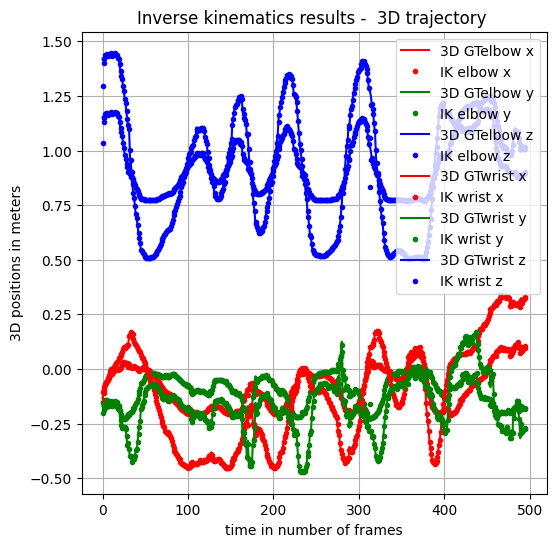

In [9]:
p2d_estim_list, p3d_estim_list = get_estimations(q, arm_robot, intrinsic_matrix, [extrinsic_matrix_coarse_init]*len(q))
plt.figure(figsize=(6, 6))
for joint_idx, joint_name in enumerate([SHOULDER, ELBOW, WRIST]):
    if joint_idx == 0:
        continue
    for dim_idx, dim in enumerate("xyz"):
        plt.plot(gt_p_full[:, joint_idx * 3 + dim_idx], color="rgb"[dim_idx], label=f"3D GT{joint_name} {dim}")
        plt.plot(p3d_estim_list[joint_name][:, dim_idx], ".", color="rgb"[dim_idx], label=f"IK {joint_name} {dim}")
plt.ylabel("3D positions in meters")
plt.xlabel("time in number of frames")
plt.title("Inverse kinematics results -  3D trajectory ")
plt.grid()
plt.legend()
plt.show()

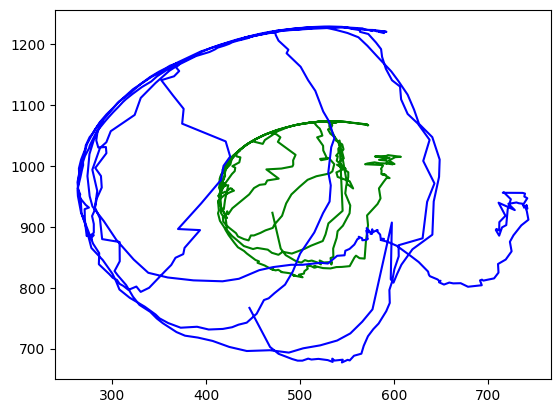

In [10]:
for frame_idx, frame in enumerate([SHOULDER, ELBOW, WRIST]):
    plt.plot(p2d_estim_list[frame][:, 0], p2d_estim_list[frame][:, 1], color="rgb"[frame_idx], label="estimated")
plt.show()

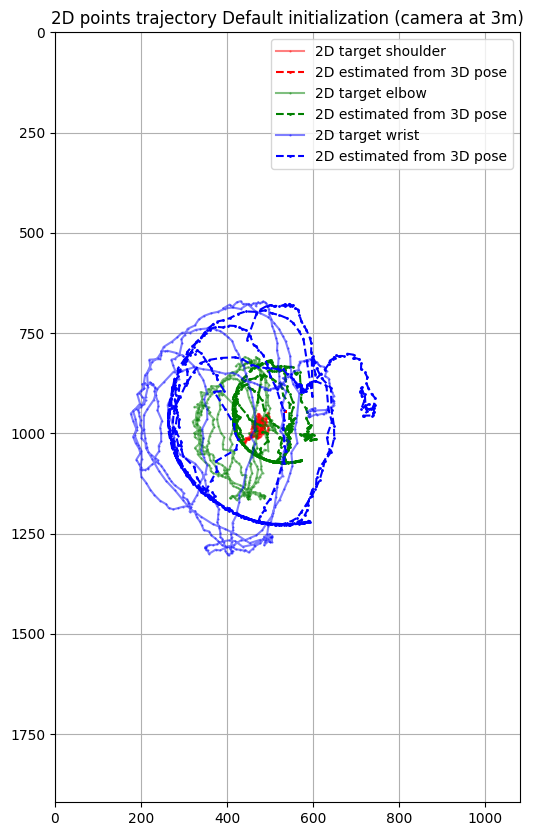

In [11]:
def plot_results(gt_p2d_full, p2d_estim_list, h=1920, w=1080, t_start=None, t_end=None, title="2D points trajectory", extra_title=""):
    plt.figure(figsize=(6, (6*h)//w))
    if t_start is None:
        t_start = 0
    if t_end is None:
        t_end = len(gt_p_full)
    for joint_idx, joint_name in enumerate([SHOULDER, ELBOW, WRIST]):
        x_gt_2D = gt_p2d_full[t_start:t_end, joint_idx * 3 + 0]*w
        y_gt_2D = gt_p2d_full[t_start:t_end, joint_idx * 3 + 1]*h

        x_reproj = p2d_estim_list[joint_name][t_start:t_end, 0]
        y_reproj = p2d_estim_list[joint_name][t_start:t_end, 1]
        plt.plot(x_gt_2D, y_gt_2D, ".-", color="rgb"[joint_idx], label=f"2D target {joint_name}", markersize=1, alpha=0.5)
        plt.plot(x_reproj, y_reproj, "--.", color="rgb"[joint_idx], label="2D estimated from 3D pose",markersize=2)

    plt.xlim(0, w)
    plt.ylim(h, 0)
    plt.grid()
    plt.legend()
    plt.title(title+extra_title)
    plt.show()
plot_results(gt_p2d_full, p2d_estim_list, extra_title=" Default initialization (camera at 3m)")

In [12]:
def diff_2D(point_prediction, point_2d_data):
    diff = point_prediction - point_2d_data
    diff = diff.flatten()
    return diff

def project_3D_to_2D(point_3d_data, intrinsic_matrix, extrinsic_matrix):
    point_2d_data = project_3D_point(point_3d_data, intrinsic_matrix, extrinsic_matrix)
    return point_2d_data



def cost_function(extrinsic_params, point_4d_data, point_2d_data, intrinsic_matrix, debug=False):
    extrinsic_matrix = np.zeros((3, 4))
    extrinsic_matrix[:3, :3] = np.eye(3)
    extrinsic_matrix[:3, -1] = -get_4D_homogeneous_vector(extrinsic_params)[:3, 0]
    # point_2d_prediction = project_3D_to_2D(point_3d_data, intrinsic_matrix, extrinsic_matrix)

    ext_vec = extrinsic_matrix.dot(point_4d_data)
    if debug:
        print("EXT 3D VECT", extrinsic_matrix.shape, point_4d_data.shape, ext_vec.shape)
        print("vect 3D to project\n", ext_vec)
    pos2d_unnormed = intrinsic_matrix.dot(ext_vec)
    # print(pos2d.shape, point_2d_data.shape)
    if debug:
        print("pos2d prediction\n", pos2d_unnormed)
    pos2d = pos2d_unnormed[:2, :]
    pos2d[0, :]/= pos2d_unnormed[2, :]
    pos2d[1, :]/= pos2d_unnormed[2, :]
    if debug:
        print("pos2d normed\n", pos2d)
        print("pos2d target\n", point_2d_data)
    
    diff = diff_2D(pos2d.T, point_2d_data)
    return diff


In [13]:
debug = False
solutions  = []
metrics = {"reprojection_error": [], "init_error": []}
for time_idx in range(len(gt_p_full)):
    x_gt_2D_array, y_gt_2D_array = [], []
    point_4d_data = []
    for joint_idx, frame in enumerate([SHOULDER, ELBOW, WRIST]):
        # if joint_idx==0:
        #     continue
        current_q = q[time_idx]
        point, jac = forward_kinematics(arm_robot, current_q, frame=frame)
        p3d = point.translation
        point_4d_data.append(get_4D_homogeneous_vector(p3d))
        x_gt_2D = gt_p2d_full[time_idx, joint_idx * 3 + 0]*w
        y_gt_2D = gt_p2d_full[time_idx, joint_idx * 3 + 1]*h
        x_gt_2D_array.append(x_gt_2D)
        y_gt_2D_array.append(y_gt_2D)
    point_2d_data = np.array([x_gt_2D_array, y_gt_2D_array]).T # 3, 3
    point_4d_data = np.array(point_4d_data)[:, :, 0].T # 3, 2
    if debug:
        print(point_4d_data.shape)
        print(point_4d_data)
    # print(point_4d_data.shape, point_2d_data.shape)
    cam_init = [0., -3., 1.0]
    init_var = cam_init
    init_cost = cost_function(init_var, point_4d_data, point_2d_data, intrinsic_matrix, debug=False)
    # print()
    solution = least_squares(cost_function, init_var, args=(point_4d_data, point_2d_data, intrinsic_matrix)).x
    # if debug
    solution_cost = cost_function(solution, point_4d_data, point_2d_data, intrinsic_matrix)
    # print(solution, np.linalg.norm(init_cost), np.linalg.norm(solution_cost))
    solutions.append(solution)
    metrics["reprojection_error"].append(np.linalg.norm(solution_cost))
    metrics["init_error"].append(np.linalg.norm(init_cost))
metrics["reprojection_error"] = np.array(metrics["reprojection_error"])
metrics["init_error"] = np.array(metrics["init_error"])

Text(0, 0.5, 'reprojection error [pixels]')

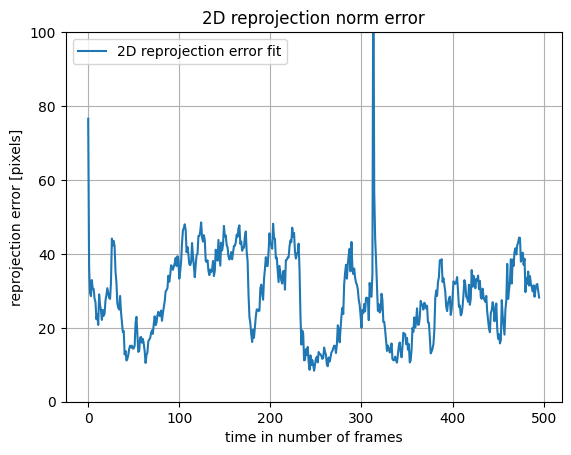

In [14]:
plt.plot(metrics["reprojection_error"], label="2D reprojection error fit")
# plt.plot(metrics["init_error"], label="2D reprojection error initialization")
plt.ylim(0, 100)
plt.grid()
plt.legend()
plt.xlabel("time in number of frames")
plt.title("2D reprojection norm error")
plt.ylabel("reprojection error [pixels]")

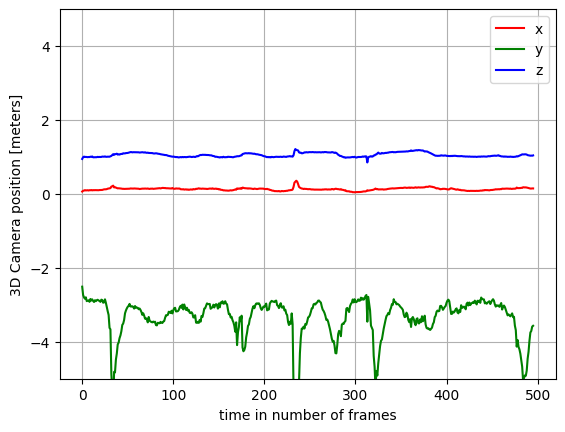

In [15]:
plt.xlabel("time in number of frames")
plt.ylabel("3D Camera position [meters]")
for dim in range(3):
    plt.plot(np.array(solutions)[:, dim], color="rgb"[dim], label="xyz"[dim])
plt.legend()
plt.ylim(-5, 5)
plt.grid()
plt.show()

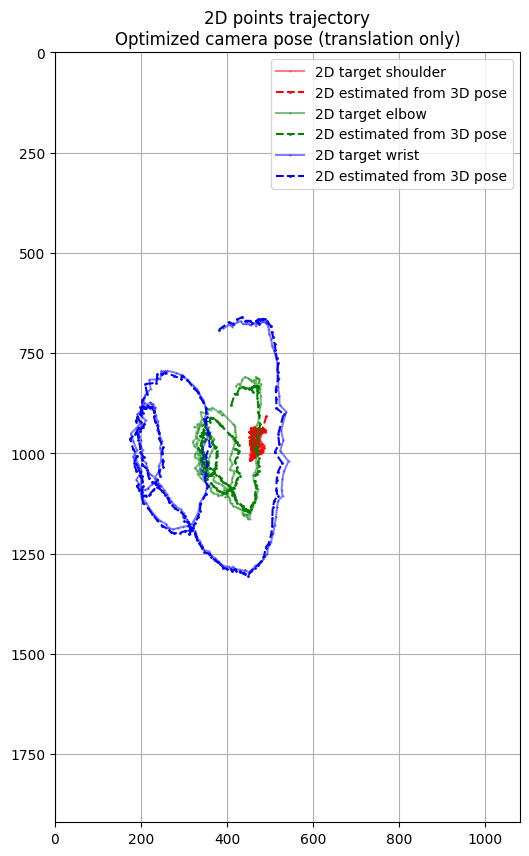

In [20]:
extrinsic_matrix_optim_list  =[]
for time_idx in range(len(solutions)):
    extrinsic_matrix_optim = np.zeros((3, 4))
    extrinsic_matrix_optim[:3, :3] = np.eye(3)
    # solution_avg = np.median(solutions, axis=0)
    cam_pos_optimized = get_4D_homogeneous_vector(solutions[time_idx])
    extrinsic_matrix_optim[:3, -1] = -cam_pos_optimized[:3, 0]
    extrinsic_matrix_optim_list.append(extrinsic_matrix_optim)

p2d_estim_list, p3d_estim_list = get_estimations(q, arm_robot, intrinsic_matrix, extrinsic_matrix_optim_list)
t_end= 200
plot_results(gt_p2d_full, p2d_estim_list, t_start=0, t_end=t_end, extra_title="\nOptimized camera pose (translation only)")
# plot_results(gt_p2d_full, p2d_estim_list)